### Import thư viện

In [15]:
%matplotlib inline

import numpy as np 
import pandas as pd
from pydicom import dcmread
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from supporters import *
from PIL import Image

### 1. Đọc và tiền xử lý ảnh file dcm

In [4]:
def load_scan(path):
    slices = [dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices


def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)  
    return np.array(image, dtype=np.int16)


def resample(image, scan, new_spacing=[1,1,1]):
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

##### Load folder tất cả bệnh nhân và load bệnh nhân thứ 2

In [11]:
INPUT_FOLDER = '../../data/PatientsDCM/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [74]:
PAT002_scan = load_scan(INPUT_FOLDER + patients[1])
PAT002 = get_pixels_hu(PAT002_scan)
PAT002.shape

(185, 512, 512)

### 2. Cắt tròn với phương trình đường tròn và lưu

In [76]:
ban_kinh = 190
a = b = 512/2

left = top = a - ban_kinh
right = bottom = a + ban_kinh

def euclidian_distance(x, y, a, b):
    dis = ((x - a)**2 + (y - b)**2)**(1/2)
    return dis

crop_imgs = []
def circling():
    for index in range(PAT002.shape[0]):
        img = PAT002[index]
        for x in range(PAT002.shape[1]):
            for y in range(PAT002.shape[2]):
                if euclidian_distance(x, y, a, b) > ban_kinh:
                    img[x,y] = -2000
        img = img[int(top) : int(bottom), int(left) : int(right)]
        crop_imgs.append(img)
        
circling()
crop_imgs = np.array(crop_imgs)
crop_imgs.shape

(185, 380, 380)

In [ ]:
PAT002 = crop_imgs
explore_3D_array(PAT002)

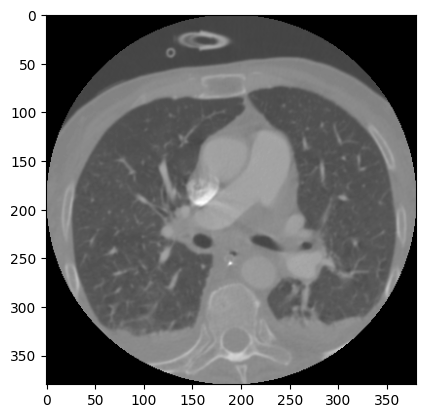

In [79]:
plt.imshow(PAT002[100], cmap="gray")

### 3. Xem và Normalize đơn vị Housefield

Đơn vị Hounsfield (HU) là một đơn vị được sử dụng để thể hiện mật độ phóng xạ của vật liệu trong chụp cắt lớp vi tính (CT). Thang đo HU dựa trên mật độ phóng xạ của không khí và nước, được gán các giá trị lần lượt là -1000 HU và 0 HU. Thang đo HU dao động từ -1000 HU đối với không khí đến +3000 HU đối với xương hoặc kim loại rất dày đặc.  Các vật liệu và mô khác nhau có giá trị HU khác nhau, có thể giúp xác định và phân biệt chúng trên hình ảnh CT.

3071 -2000


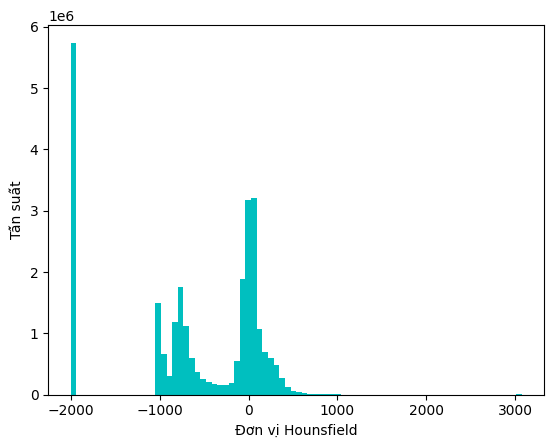

In [80]:
print(np.max(PAT002), np.min(PAT002))

plt.hist(PAT002.flatten(), bins=80, color='c')
plt.xlabel("Đơn vị Hounsfield")
plt.ylabel("Tấn suất")
plt.show()

Tuy nhiên range Hounsfield Unit ở trên chưa chính xác trong vùng hình tròn và có một vài nhiễu +3000

In [85]:
def normalization():
    max_val = min_val = 0
    # Find max min
    for index in range(PAT002.shape[0]):
            img = PAT002[index]
            for x in range(PAT002.shape[1]):
                for y in range(PAT002.shape[2]):
                    if euclidian_distance(x, y, a=PAT002.shape[1]/2, b=PAT002.shape[1]/2) <= ban_kinh: # nằm trong hình tròn
                        if img[x,y] > max_val:
                            max_val = img[x,y] 
                        elif img[x,y] < max_val:
                            min_val = img[x,y] 
    # Intensity normalization                        
    for index in range(PAT002.shape[0]):
        img = PAT002[index]
        for x in range(PAT002.shape[1]):
            for y in range(PAT002.shape[2]):
                if euclidian_distance(x, y, a=PAT002.shape[1]/2, b=PAT002.shape[1]/2) <= ban_kinh: # nằm trong hình tròn
                    img = (img - min_val) / (max_val - min_val)
                    PAT002[index] = img

(3071, -878)

Hoặc Normalize với range tùy chọn

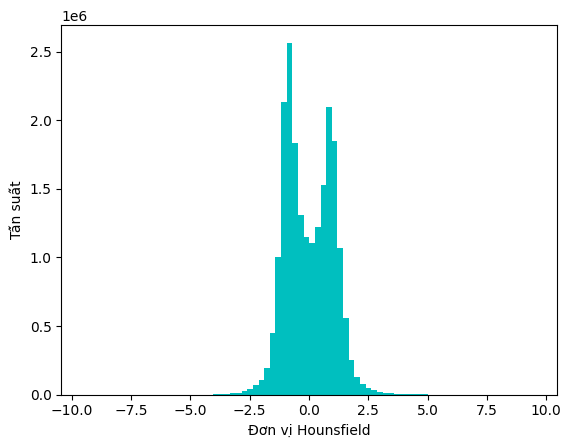

In [88]:
from scipy import stats

in_range = (-1024, 1024)
mask = (PAT002 >= in_range [0]) & (PAT002 <= in_range [1])
masked_array = np.ma.masked_array (PAT002, ~mask)
normalized_array = stats.zscore (masked_array, axis = 0)
normalized_array = normalized_array.filled (0)

plt.hist(normalized_array.flatten(), bins=80, color='c')
plt.xlabel("Đơn vị Hounsfield")
plt.ylabel("Tấn suất")
plt.show()